In [1]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re;
import nltk;
from nltk.corpus import stopwords;
import bs4;
import sklearn.model_selection

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['train.csv', 'test.csv']


In [2]:
train = pd.read_csv('../input/train.csv')

In [3]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [4]:
label_info = train['label'].value_counts()
print('Number of racist and sexist tweets: {}'.format(label_info[1]))
print('Number of not racist and sexist tweets: {}'.format(label_info[0]));

print('There are {}% racist and sexist tweet'.format(label_info[1] / train.shape[0] * 100));

Number of racist and sexist tweets: 2242
Number of not racist and sexist tweets: 29720
There are 7.014579813528565% racist and sexist tweet


- tweet columns contains tweets by users
- Most of the tweet has @user in them, which defines tweeter user handles, so i'll remove them as it's won't give any sentiment information.
- Things to remove:
    * special characters
    * words with numbers
    * numbers
    * @user word
   

In [5]:
def decontraction(text):
    patterns = [
            ('won\'t', 'will not'), ('\'d', ' would'), ('\'s', ' is'), ('can\'t', 'can not'),
            ('don\'t', 'do not'), ('\'ll', ' will'), ('\'ve', ' have'), ('\'t', ' not'),
            ('\'re', ' are'), ('\'m', ' am')
    ];
    
    for (pattern, replacer) in patterns:
        regex = re.compile(pattern);
        text = regex.sub(replacer, text);
    return text;

In [6]:
STOP_WORDS = stopwords.words('english');
STOP_WORDS.remove('not');


In [7]:
from nltk.stem.porter import PorterStemmer;

def process_text(text):
    
    #performing decontraction
    text = decontraction(text);
    
    #removing html tags
    if type(text) == type(''):
        bs = bs4.BeautifulSoup(text) #removing html tags
        text = bs.get_text()
        
    #removing @user
    text = text.replace('@user', ' ');
    
    #removing special characters except # as in tweeter it contains trends specific word along with #
    text = re.sub('[^A-Za-z#]', ' ', text);
    
    #removing words with numbers
    text = re.sub('\S*\d\S*', ' ', text);
    
    #removing stop words except not, because not helps in finding negative sentiments
    text = ' '.join([word for word in text.split(' ') if word.lower() not in STOP_WORDS])
    
    #removing words having lenght <=2
    text = ' '.join([word for word in text.split(' ') if len(word) > 2])
    
    #converting whole text into lower case
    text = text.lower().strip();
    
    #stemming words
    stemmer = PorterStemmer();
    text = ' '.join([stemmer.stem(word) for word in text.split(' ')])
    
    return text;

In [8]:
train['clean_tweet'] = train['tweet'].fillna('').apply(process_text)
train.head()

,id,label,tweet,clean_tweet
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit not use caus not offer whee...
2,3,0,bihday your majesty,bihday majesti
3,4,0,#model i love u take with u all the time in ...,#model love take time
4,5,0,factsguide: society now #motivation,factsguid societi #motiv


**UPSAMPLING to balance train data**

In [9]:
#https://elitedatascience.com/imbalanced-classes

from sklearn.utils import resample;

train_majority = train[train['label'] == 0];
print('majority data size: ', train_majority.shape);

train_minority = train[train['label'] == 1];
print('minority data size: ', train_minority.shape);

minority_upsampled = resample(train_minority, replace=True, n_samples=29720, random_state=1)
print('upsampled data size: ', minority_upsampled.shape)

#concating majority and upsampled minority data
train_upsampled = pd.concat([train_majority, minority_upsampled]);
print('new upsampled data: ', train_upsampled.shape)

majority data size:  (29720, 4)
minority data size:  (2242, 4)
upsampled data size:  (29720, 4)
new upsampled data:  (59440, 4)


In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentimentAnalyzer = SentimentIntensityAnalyzer();
train_upsampled['polarity_score'] = train_upsampled['clean_tweet'].apply(lambda tweet: sentimentAnalyzer.polarity_scores(tweet)['compound']);

train_upsampled.head()

/opt/conda/lib/python3.6/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


,id,label,tweet,clean_tweet,polarity_score
0,1,0,@user when a father is dysfunctional and is s...,father dysfunct selfish drag kid dysfunct #run,-0.6124
1,2,0,@user @user thanks for #lyft credit i can't us...,thank #lyft credit not use caus not offer whee...,0.6249
2,3,0,bihday your majesty,bihday majesti,0.0000
3,4,0,#model i love u take with u all the time in ...,#model love take time,0.6369
4,5,0,factsguide: society now #motivation,factsguid societi #motiv,0.0000


**Splitting data into train, test and cv**

In [11]:
df = train_upsampled.drop('tweet', axis=1);
df.head()

,id,label,clean_tweet,polarity_score
0,1,0,father dysfunct selfish drag kid dysfunct #run,-0.6124
1,2,0,thank #lyft credit not use caus not offer whee...,0.6249
2,3,0,bihday majesti,0.0000
3,4,0,#model love take time,0.6369
4,5,0,factsguid societi #motiv,0.0000


In [12]:
X = df.loc[:, ['clean_tweet', 'polarity_score']];
y = df.loc[:, ['label']]

In [13]:
from sklearn.model_selection import train_test_split
#splitting project_data into train and test and CV data.
X_1, X_test, y_1, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
X_train, X_cv, y_train, y_cv = train_test_split(X_1, y_1, test_size=0.3, random_state=1);

print('shape of train data ', X_train.shape);
print('shape of test data ', X_test.shape);
print('shape of cross validation data ', X_cv.shape)

shape of train data  (29125, 2)
shape of test data  (17832, 2)
shape of cross validation data  (12483, 2)


**vectorizing clean_tweet using TfidfVectorizer**

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer;

vectorizer = TfidfVectorizer(ngram_range=(1,2), max_df=0.8, max_features=5000);
vectorizer.fit(X_train['clean_tweet']);

train_tweet = vectorizer.transform(X_train['clean_tweet']);
test_tweet = vectorizer.transform(X_test['clean_tweet']);
cv_tweet = vectorizer.transform(X_cv['clean_tweet']);

print('shape of train tweet ', train_tweet.shape);
print('shape of test tweet ', test_tweet.shape);
print('shape of cv tweet ', cv_tweet.shape)

shape of train tweet  (29125, 5000)
shape of test tweet  (17832, 5000)
shape of cv tweet  (12483, 5000)


In [15]:
#merging data
from scipy.sparse import hstack

train = hstack((train_tweet, X_train['polarity_score'].values.reshape(-1,1))).tocsr();
test = hstack((test_tweet, X_test['polarity_score'].values.reshape(-1,1))).tocsr();
cv = hstack((cv_tweet, X_cv['polarity_score'].values.reshape(-1,1))).tocsr();

In [16]:
# writing our own function for predict, with defined thresould
# we will pick a threshold that will give the least fpr
def predict(proba, threshold, fpr, tpr):
    
    t = threshold[np.argmax(tpr*(1-fpr))]
    
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    predictions = []
    for i in proba:
        if i>=t:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#defining function to plot confusion matrix
def plot_confusion_matrix(y, pred_y):
    plt.figure(figsize=(20,4))
    
    cm = confusion_matrix(y, pred_y)

    labels = np.array(["{0}={1}".format(text, auc) for auc, text in zip(cm.flatten(), ['TN', 'FP', 'FN', 'TP'])]).reshape(2,2);
    plt.subplot(1, 3, 1);
    sns.heatmap(cm, annot=labels, fmt="");
    plt.xlabel('Predicted Values');
    plt.ylabel('Actual Values');
    plt.title('Confusion Matrix');
    
    #plotting precision matrix
    precission_matrix = (cm / cm.sum(axis=0));
    plt.subplot(1, 3, 2);
    sns.heatmap(precission_matrix, annot=True, fmt="");
    plt.xlabel('Predicted Values');
    plt.ylabel('Actual Values');
    plt.title('Precission Matrix');
    
    #plotting recall matrix
    recall_matrix = (cm.T / cm.sum(axis=0));
    plt.subplot(1, 3, 3);
    sns.heatmap(recall_matrix, annot=True, fmt="" );
    plt.xlabel('Predicted Values');
    plt.ylabel('Actual Values');
    plt.title('Recall Matrix');
    
    Precision = precission_matrix[1][1];
    Recall = recall_matrix[1][1];
    
    f1_score =  2*(Recall * Precision) / (Recall + Precision)
    
    print('f1 score: ', f1_score)

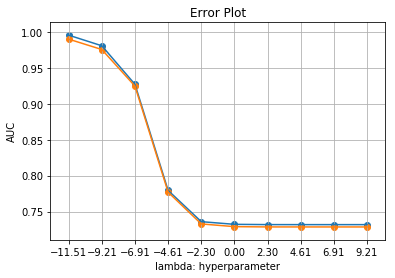

In [18]:
from sklearn.linear_model import SGDClassifier;
from sklearn.metrics import roc_auc_score;
import matplotlib.pyplot as plt;
#creating list for holding auc value for train, cv
train_auc = [];
cv_auc = [];

#defining list of lambda's
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000];

for a in alpha:
    #using SGDClassifier, and passing log in loss, which makes it LogisticRegression
    LR = SGDClassifier(loss='log', penalty='l2', alpha=a); #usig L2 Regularization
    LR.fit(train, y_train['label'].values.ravel()); #training model using training data.
    
    y_train_pred = LR.predict_proba(train)[:, 1]; #predicting probability for training data
    y_cv_pred = LR.predict_proba(cv)[:, 1]; #predicting probability for cv data
    
    train_auc.append(roc_auc_score(y_train, y_train_pred));
    cv_auc.append(roc_auc_score(y_cv, y_cv_pred));
    
#plotting error plot
plt.plot(np.log(alpha), train_auc, label='Train AUC');
plt.plot(np.log(alpha), cv_auc, label='CV AUC');

plt.scatter(np.log(alpha), train_auc, label='Train AUC points');
plt.scatter(np.log(alpha), cv_auc, label='CV AUC points');
    
plt.xlabel('lambda: hyperparameter');
plt.ylabel('AUC');
plt.title('Error Plot');

plt.xticks(np.log(alpha))

plt.grid();
plt.show()

0.0001


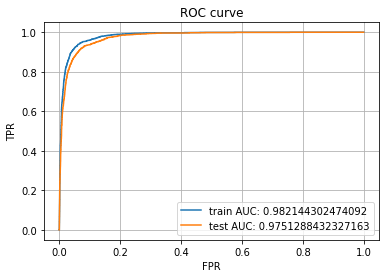

In [19]:

from sklearn.metrics import roc_curve;

optimal_alpha = 0.0001
tfidf_lr_alpha = optimal_alpha;
print(optimal_alpha)
#training model using optimal_alpha
LR = SGDClassifier(loss='log', penalty='l2', alpha=optimal_alpha);

LR.fit(train, y_train.values.ravel());

y_train_pred = LR.predict_proba(train)[:, 1];
y_test_pred = LR.predict_proba(test)[:, 1];

train_fpr, train_tpr, train_thresholds = roc_curve(y_train, y_train_pred);
test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_pred);

train_auc = roc_auc_score(y_train, y_train_pred);
test_auc = roc_auc_score(y_test, y_test_pred);
                            
tfidf_lr_auc = test_auc;

#plotting ROC curve
plt.plot(train_fpr, train_tpr, label="train AUC: "+str(train_auc))
plt.plot(test_fpr, test_tpr, label="test AUC: "+str(test_auc))


plt.grid();
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.legend();
plt.show()

Train confusion matrix: 
the maximum value of tpr*(1-fpr) 0.8807928380758022 for threshold 0.542
f1 score:  0.938871794871795


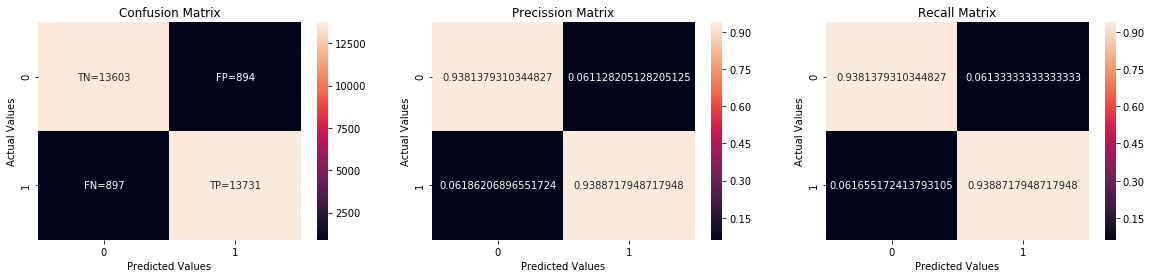

In [30]:
print('Train confusion matrix: ');
train_pred = predict(y_train_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_train, train_pred);

Test confusion matrix: 
the maximum value of tpr*(1-fpr) 0.8807928380758022 for threshold 0.542
f1 score:  0.9257336343115125


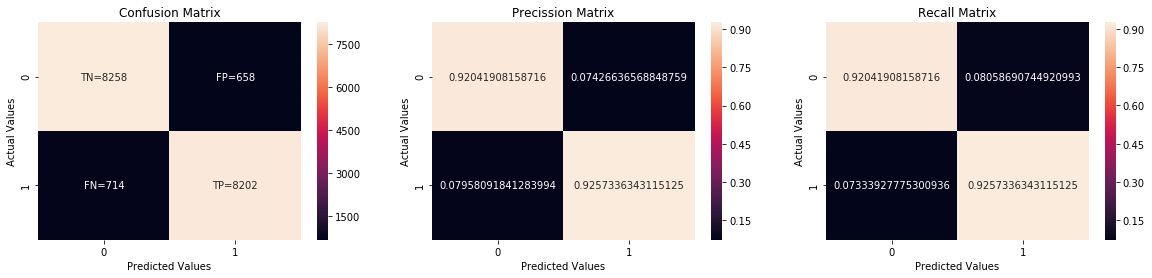

In [31]:
print('Test confusion matrix: ');
test_pred = predict(y_test_pred, train_thresholds, train_fpr, train_tpr);
plot_confusion_matrix(y_test, test_pred);